#### DL/DLOps (2023)

# Lab Assignment 8: Weights & Biases

Submitted By **Debonil Ghosh [ M21AIE225 ]**

**Question 1 [100 marks]**

Train a ResNet18 model for classification on even classes of CIFAR-10 (for  students with even roll no)/ odd classes of FashionMNIST (for students with odd roll no) for 30 epochs. Analyze the training of model using wandb library and “weights & biases” tool covered in the class.

In [192]:
!pip install wandb -qU


In [193]:
# Log in to your W&B account
import wandb
wandb.login()


True

In [194]:
import torch
import torch.nn
import torch.optim
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T
from sklearn import metrics
import seaborn as sns
import time
import math
import numpy as np
import matplotlib.pyplot as plt


In [195]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Available device ==> {device}')


Available device ==> cuda:0


Filtering other than ODD classes 1,3,5,7,9 as roll number is odd (M21AIE225)

In [196]:
def filter_dataset(dataset_full):
    # Selecting ODD classes 1,3,5,7,9 as roll number is odd (M21AIE225)
    targets = np.array(dataset_full.targets)
    idx = (targets == 1) | (targets == 3) | (
        targets == 5) | (targets == 7) | (targets == 9)
    dataset_full.targets = np.floor(targets[idx]/2).astype(int)
    dataset_full.data = dataset_full.data[idx]
    dataset_full.classes = [dataset_full.classes[c] for c in [1,3,5,7,9]]
    return dataset_full

Dataset is **FashionMNIST** as roll number is odd

In [197]:
transform = T.Compose(
    [T.ToTensor(),
        T.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)
train_set = filter_dataset(train_set)
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True)
test_set = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)
test_set = filter_dataset(test_set)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
print(train_set.data.shape)
print(train_set.classes)


torch.Size([30000, 28, 28])
['Trouser', 'Dress', 'Sandal', 'Sneaker', 'Ankle boot']


In [198]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="m21aie225-lab-assignment-8",

    # track hyperparameters and run metadata
    config={
        "learning_rate": 0.0001,
        "architecture": "ResNet18",
        "dataset": "FashionMNIST",
        "epochs": 30,
    }
)


In [199]:
def get_model(act_fn=None,out_classes = len(test_set.classes)):
    model = torchvision.models.resnet18(
        weights=None)
    model.conv1 = torch.nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding, bias=model.conv1.bias)
    model.fc = torch.nn.Linear(model.fc.in_features, out_classes)
    if act_fn != None:
      model.relu = getattr(torch.nn, act_fn)()
      for i in range(4):
        for j,module in enumerate(model.get_submodule(f'layer{i+1}')):
          module.relu = getattr(torch.nn, act_fn)()
    model = model.to(device)
    return model

print(get_model())


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [200]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [201]:
# Train the model
def model_training(model, criterion, optimizer, trainloader, testloader, num_epochs=10):
    start = time.time()
    loss_list = []
    for epoch in range(num_epochs):
        epoch_start = time.time()
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += metrics.accuracy_score(labels.cpu().detach(
            ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += metrics.accuracy_score(labels.cpu().detach(
                ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        val_loss = val_loss/len(testloader)
        train_acc = train_acc/len(trainloader)
        val_acc = val_acc/len(testloader)
        print(f'Epoch: {epoch+1} ({timeSince(start)}) \tTraining Loss: {train_loss:.3f}, \tTest Loss: {val_loss:.3f},  \tTraining acc: {train_acc:.2f}, \tTest acc: {val_acc:.2f}, ')
        loss_list.append([train_loss, val_loss, train_acc, val_acc])
        wandb.log({"epoch": epoch+1, "train/train_loss": loss, "val/val_loss": val_loss,
                  "train/train_accuracy": train_acc, "val/val_accuracy": val_acc, "epoch_time": (time.time()-epoch_start)})
    print(
        f'Training completed in {timeSince(start)} \tTraining Loss: {loss_list[-1][0]:.3f}, \tTest Loss: {loss_list[-1][1]:.3f},  \tTraining acc: {loss_list[-1][2]:.2f}, \tTest acc: {loss_list[-1][3]:.2f}, ')
    return np.array(loss_list), time.time()-start, loss_list[-1][2], loss_list[-1][3]


In [202]:
from sklearn import metrics
import seaborn as sns
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})
import pandas as pd

def confusionMatrixAndAccuracyReport(Y_test, Y_pred, classes, title=''):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    f1_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

    plt.figure(figsize=(10, 10))
    plt.title(
        f'{title} : Accuracy : {overallAccuracy*100:3.2f}% | F1 Score : {f1_score*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues',
                fmt='g', xticklabels=classes, yticklabels=classes)

    plt.show()
    plt.savefig(
        f'confusion_mat_{title}_{time.time()}.png', bbox_inches='tight')
    print(f'Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'F1 Score: {f1_score*100:3.3f}%')
    classwiseAccuracy_df = pd.DataFrame(
        data=[classwiseAccuracy], columns=classes)
    print(
        f'\nClasswise Accuracy Score: \n{classwiseAccuracy_df.to_markdown(index=False)}')
    print('\nConfusion Matrix:')
    print(cm.to_markdown())
    wandb.log({"accuracy_score":overallAccuracy,"f1_score":f1_score,})


In [203]:
def plot_training_graphs(loss_list):
    fig = plt.figure(figsize=(20, 7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title("Training vs Validation loss")
    plot.plot(loss_list[:, 0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:, 1], linestyle='-', label="Validation Loss")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title("Training vs Validation Accuracy")
    plot.plot(loss_list[:, 2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:, 3], linestyle='-', label="Validation Accuracy")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()


In [204]:
def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[test_set.classes[i] for i in range(len(test_set.classes))])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), test_set.classes[pred], test_set.classes[targ], *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

Epoch: 1 (0m 22s) 	Training Loss: 0.181, 	Test Loss: 0.123,  	Training acc: 0.94, 	Test acc: 0.96, 
Epoch: 2 (0m 44s) 	Training Loss: 0.087, 	Test Loss: 0.100,  	Training acc: 0.97, 	Test acc: 0.96, 
Epoch: 3 (1m 6s) 	Training Loss: 0.065, 	Test Loss: 0.091,  	Training acc: 0.98, 	Test acc: 0.97, 
Epoch: 4 (1m 28s) 	Training Loss: 0.052, 	Test Loss: 0.091,  	Training acc: 0.98, 	Test acc: 0.97, 
Epoch: 5 (1m 51s) 	Training Loss: 0.040, 	Test Loss: 0.111,  	Training acc: 0.98, 	Test acc: 0.97, 
Epoch: 6 (2m 13s) 	Training Loss: 0.034, 	Test Loss: 0.097,  	Training acc: 0.99, 	Test acc: 0.97, 
Epoch: 7 (2m 36s) 	Training Loss: 0.029, 	Test Loss: 0.116,  	Training acc: 0.99, 	Test acc: 0.97, 
Epoch: 8 (2m 58s) 	Training Loss: 0.026, 	Test Loss: 0.084,  	Training acc: 0.99, 	Test acc: 0.98, 
Epoch: 9 (3m 21s) 	Training Loss: 0.024, 	Test Loss: 0.111,  	Training acc: 0.99, 	Test acc: 0.97, 
Epoch: 10 (3m 43s) 	Training Loss: 0.019, 	Test Loss: 0.102,  	Training acc: 0.99, 	Test acc: 0.97, 


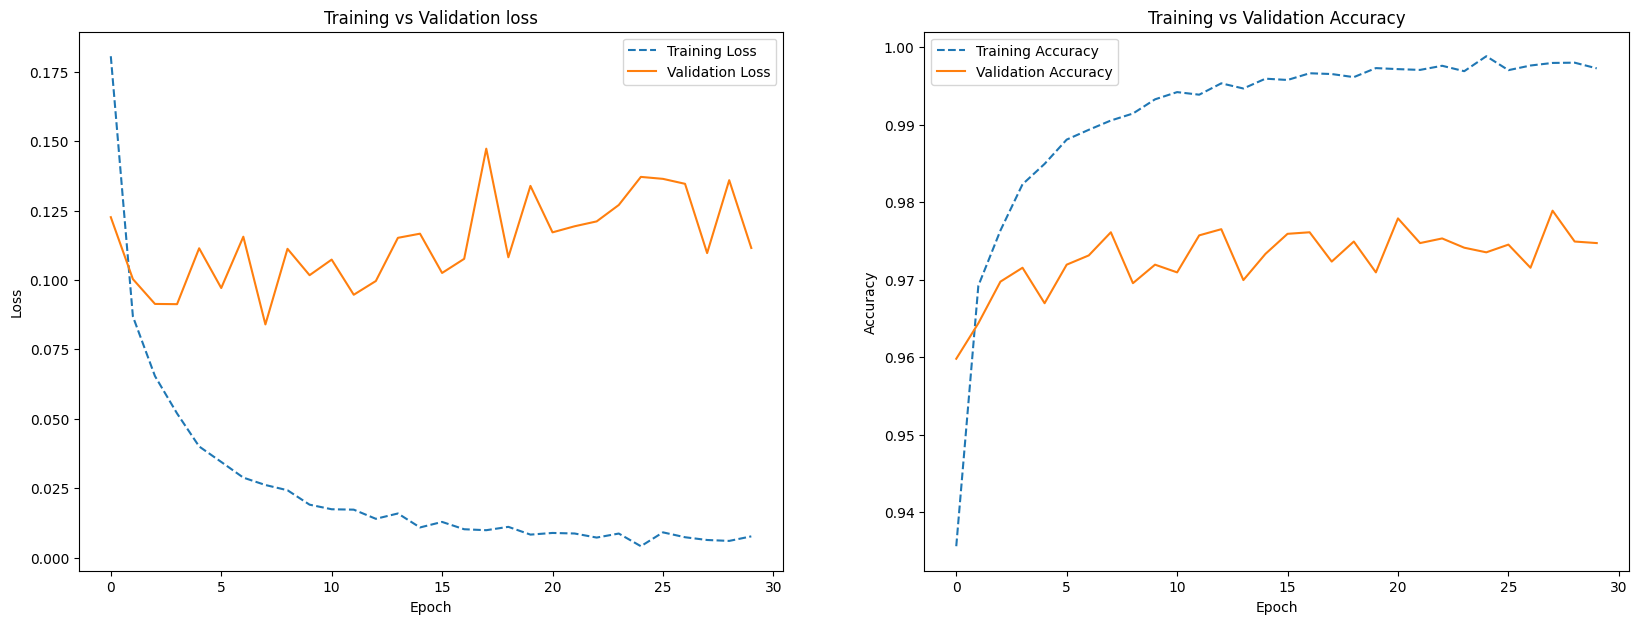

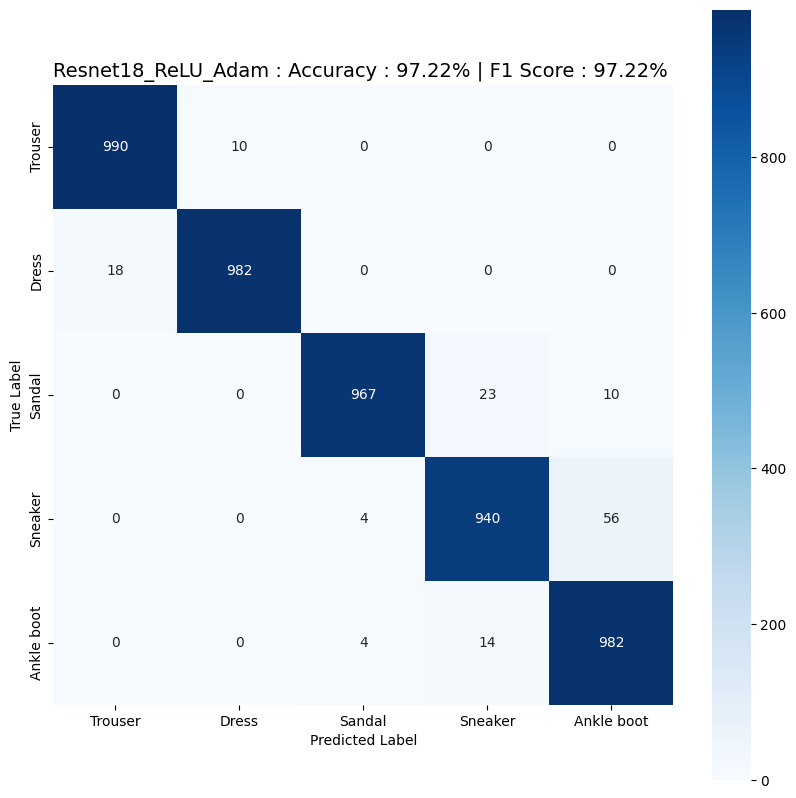

Accuracy: 97.220%
F1 Score: 97.223%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|      0.99 |   0.982 |    0.967 |      0.94 |        0.982 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       990 |      10 |        0 |         0 |            0 |
| Dress        |        18 |     982 |        0 |         0 |            0 |
| Sandal       |         0 |       0 |      967 |        23 |           10 |
| Sneaker      |         0 |       0 |        4 |       940 |           56 |
| Ankle boot   |         0 |       0 |        4 |        14 |          982 |
Epoch: 1 (0m 22s) 	Training Loss: 0.296, 	Test Loss: 0.212,  	Training acc: 0.90, 	Test acc: 0.93, 
Epoch: 2 (0m 44s) 	Training Loss: 0.181, 	Test Loss: 0.180,  	Training acc: 0.94, 	Test acc:

<Figure size 640x480 with 0 Axes>

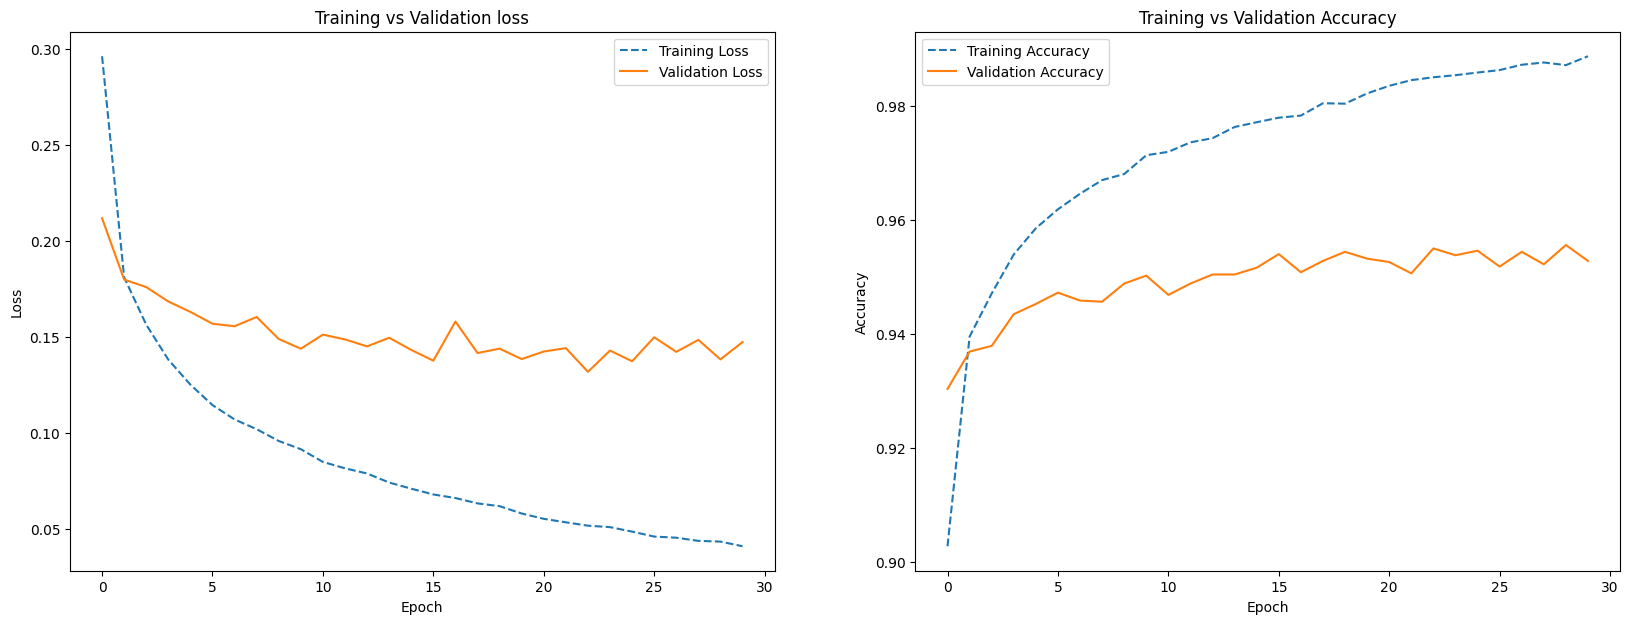

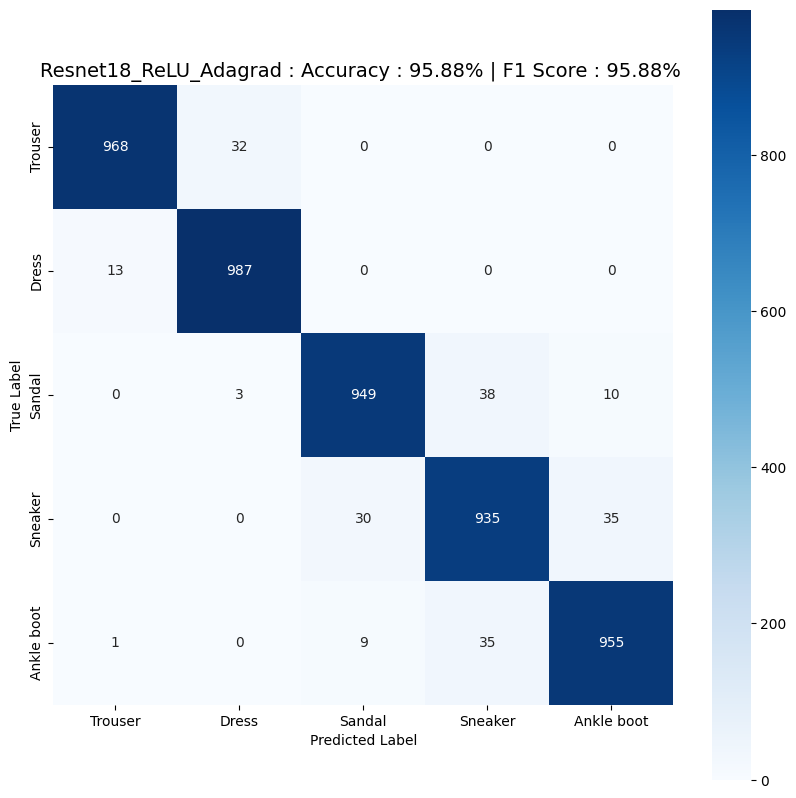

Accuracy: 95.880%
F1 Score: 95.881%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.968 |   0.987 |    0.949 |     0.935 |        0.955 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       968 |      32 |        0 |         0 |            0 |
| Dress        |        13 |     987 |        0 |         0 |            0 |
| Sandal       |         0 |       3 |      949 |        38 |           10 |
| Sneaker      |         0 |       0 |       30 |       935 |           35 |
| Ankle boot   |         1 |       0 |        9 |        35 |          955 |
Epoch: 1 (0m 21s) 	Training Loss: 0.164, 	Test Loss: 0.124,  	Training acc: 0.94, 	Test acc: 0.96, 
Epoch: 2 (0m 42s) 	Training Loss: 0.093, 	Test Loss: 0.130,  	Training acc: 0.97, 	Test acc:

<Figure size 640x480 with 0 Axes>

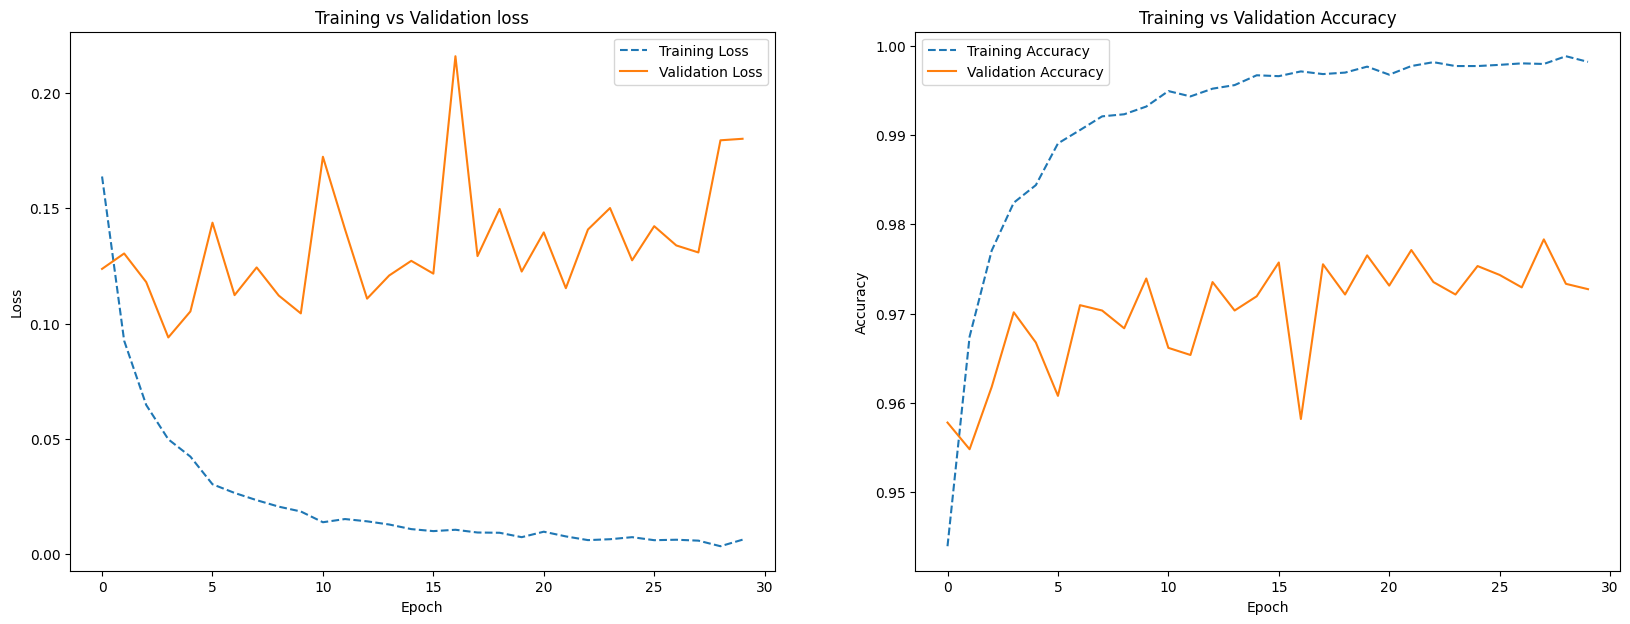

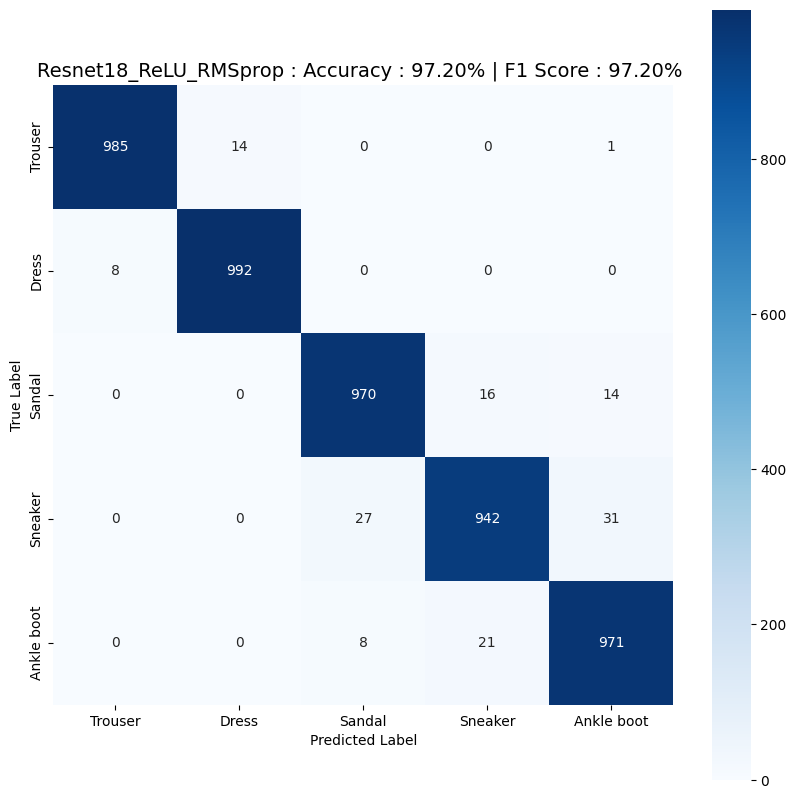

Accuracy: 97.200%
F1 Score: 97.198%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.985 |   0.992 |     0.97 |     0.942 |        0.971 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       985 |      14 |        0 |         0 |            1 |
| Dress        |         8 |     992 |        0 |         0 |            0 |
| Sandal       |         0 |       0 |      970 |        16 |           14 |
| Sneaker      |         0 |       0 |       27 |       942 |           31 |
| Ankle boot   |         0 |       0 |        8 |        21 |          971 |
Epoch: 1 (0m 20s) 	Training Loss: 0.850, 	Test Loss: 0.504,  	Training acc: 0.73, 	Test acc: 0.86, 
Epoch: 2 (0m 39s) 	Training Loss: 0.409, 	Test Loss: 0.356,  	Training acc: 0.88, 	Test acc:

<Figure size 640x480 with 0 Axes>

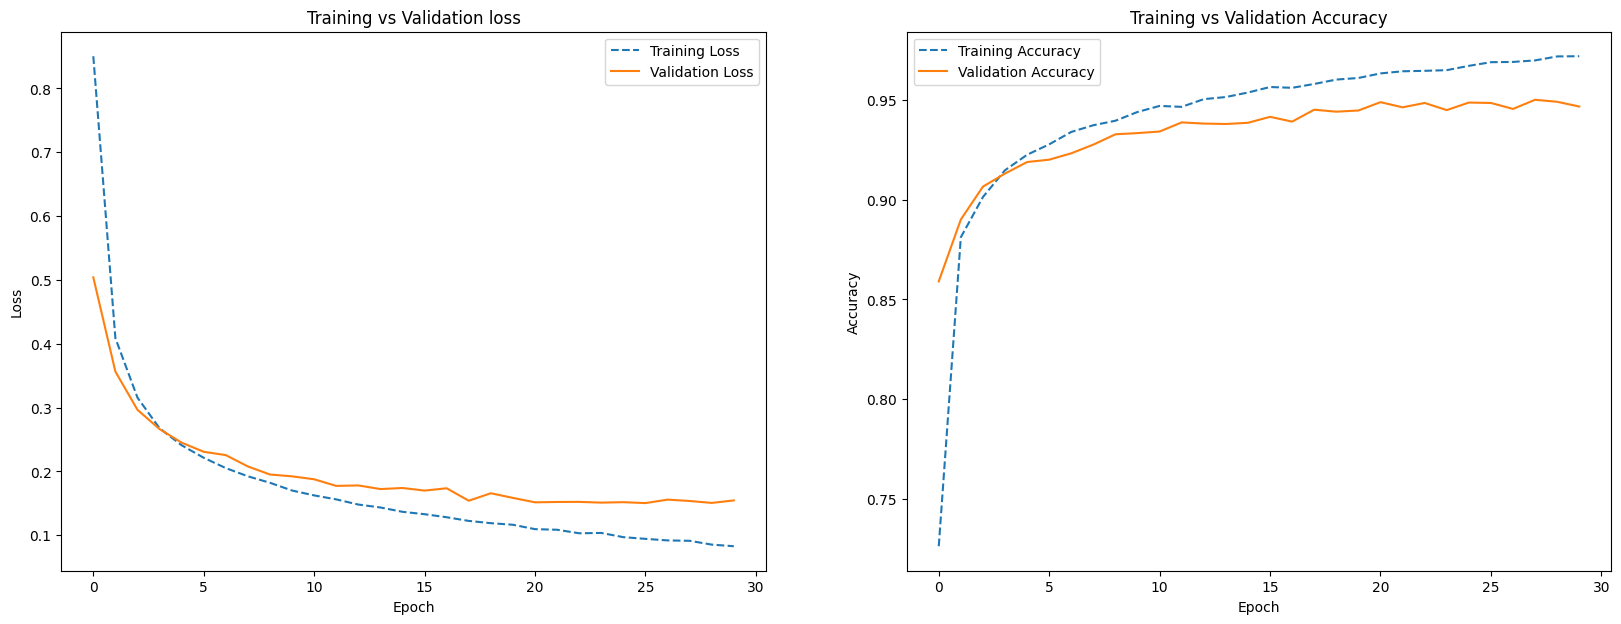

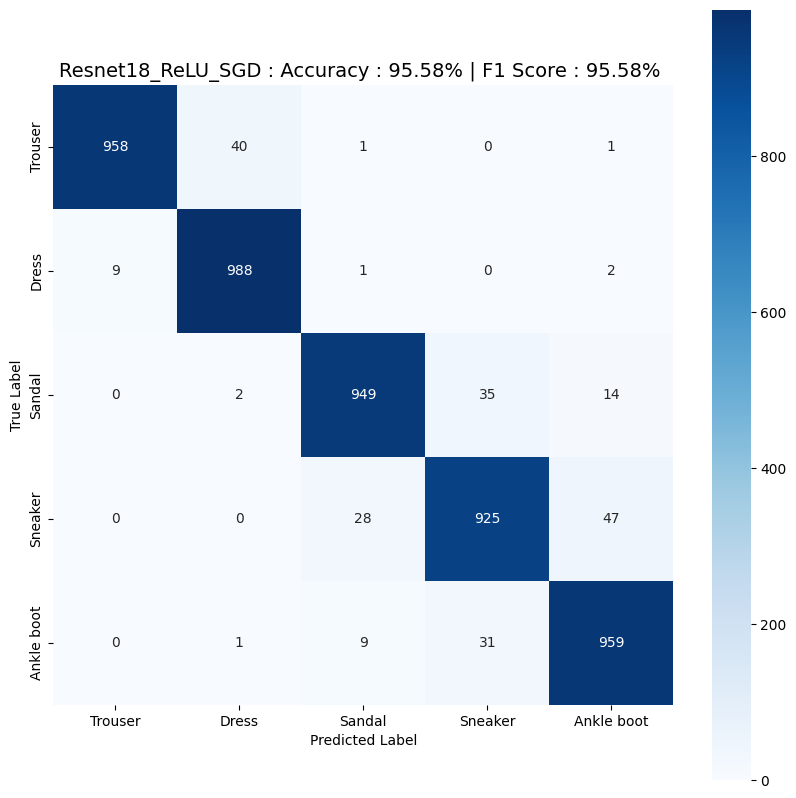

Accuracy: 95.580%
F1 Score: 95.580%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.958 |   0.988 |    0.949 |     0.925 |        0.959 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       958 |      40 |        1 |         0 |            1 |
| Dress        |         9 |     988 |        1 |         0 |            2 |
| Sandal       |         0 |       2 |      949 |        35 |           14 |
| Sneaker      |         0 |       0 |       28 |       925 |           47 |
| Ankle boot   |         0 |       1 |        9 |        31 |          959 |
Epoch: 1 (0m 22s) 	Training Loss: 0.170, 	Test Loss: 0.132,  	Training acc: 0.94, 	Test acc: 0.96, 
Epoch: 2 (0m 44s) 	Training Loss: 0.098, 	Test Loss: 0.123,  	Training acc: 0.97, 	Test acc:

<Figure size 640x480 with 0 Axes>

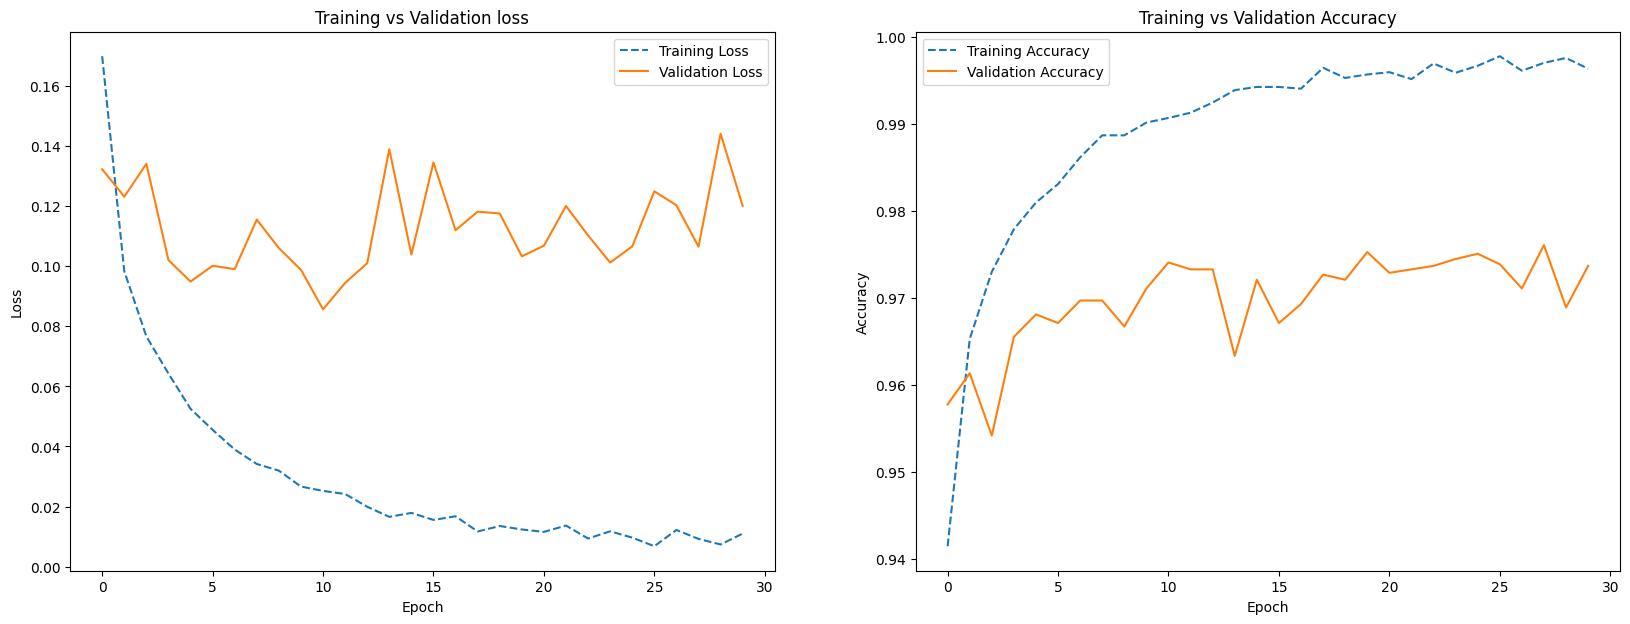

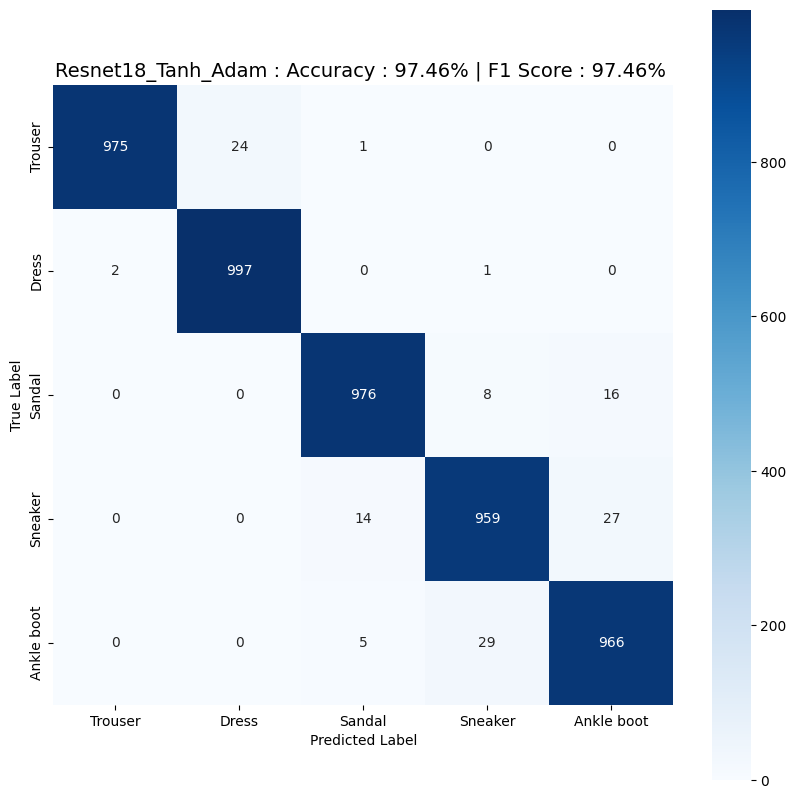

Accuracy: 97.460%
F1 Score: 97.461%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.975 |   0.997 |    0.976 |     0.959 |        0.966 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       975 |      24 |        1 |         0 |            0 |
| Dress        |         2 |     997 |        0 |         1 |            0 |
| Sandal       |         0 |       0 |      976 |         8 |           16 |
| Sneaker      |         0 |       0 |       14 |       959 |           27 |
| Ankle boot   |         0 |       0 |        5 |        29 |          966 |
Epoch: 1 (0m 22s) 	Training Loss: 0.232, 	Test Loss: 0.176,  	Training acc: 0.93, 	Test acc: 0.94, 
Epoch: 2 (0m 45s) 	Training Loss: 0.145, 	Test Loss: 0.156,  	Training acc: 0.95, 	Test acc:

<Figure size 640x480 with 0 Axes>

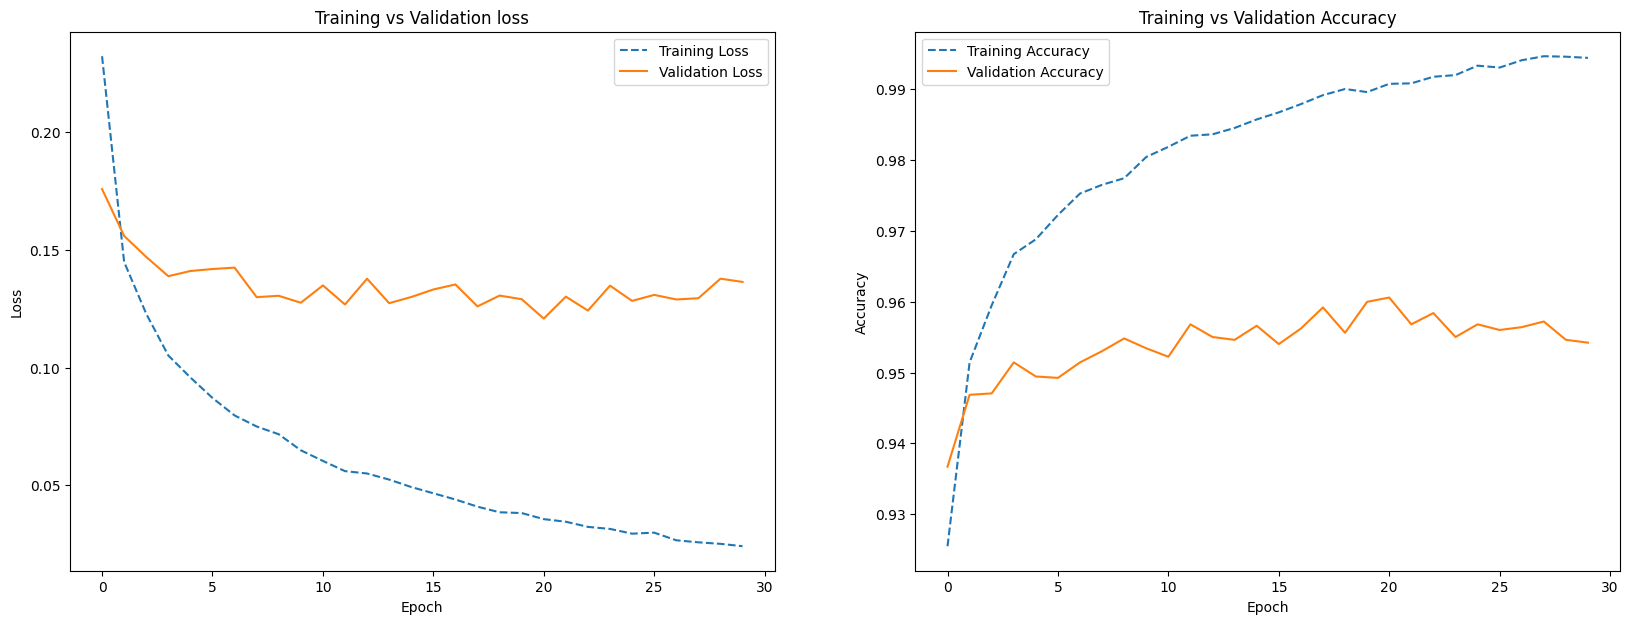

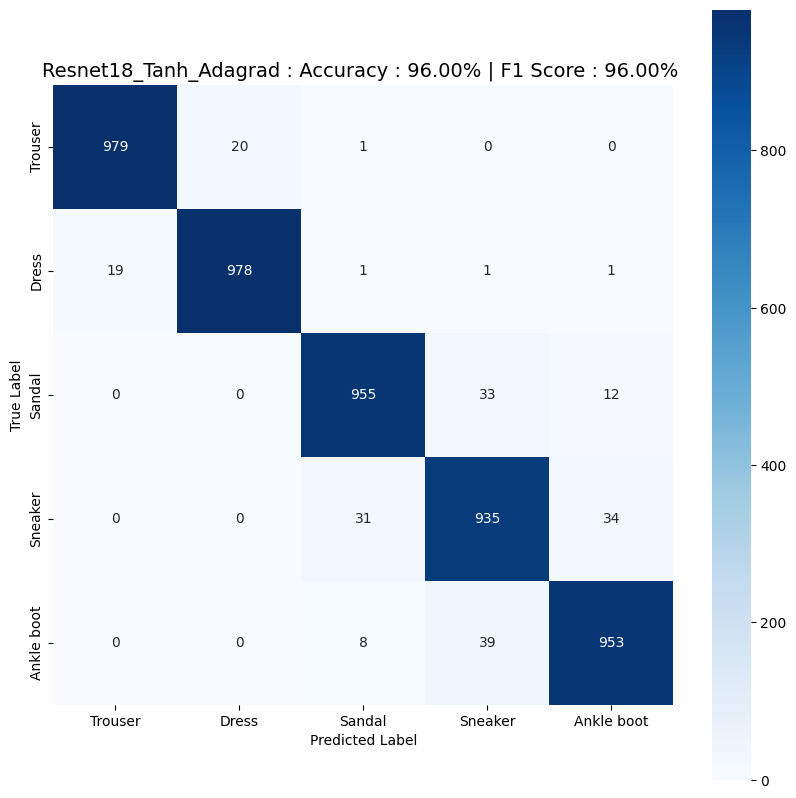

Accuracy: 96.000%
F1 Score: 96.003%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.979 |   0.978 |    0.955 |     0.935 |        0.953 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       979 |      20 |        1 |         0 |            0 |
| Dress        |        19 |     978 |        1 |         1 |            1 |
| Sandal       |         0 |       0 |      955 |        33 |           12 |
| Sneaker      |         0 |       0 |       31 |       935 |           34 |
| Ankle boot   |         0 |       0 |        8 |        39 |          953 |
Epoch: 1 (0m 21s) 	Training Loss: 0.167, 	Test Loss: 0.131,  	Training acc: 0.94, 	Test acc: 0.96, 
Epoch: 2 (0m 42s) 	Training Loss: 0.100, 	Test Loss: 0.148,  	Training acc: 0.96, 	Test acc:

<Figure size 640x480 with 0 Axes>

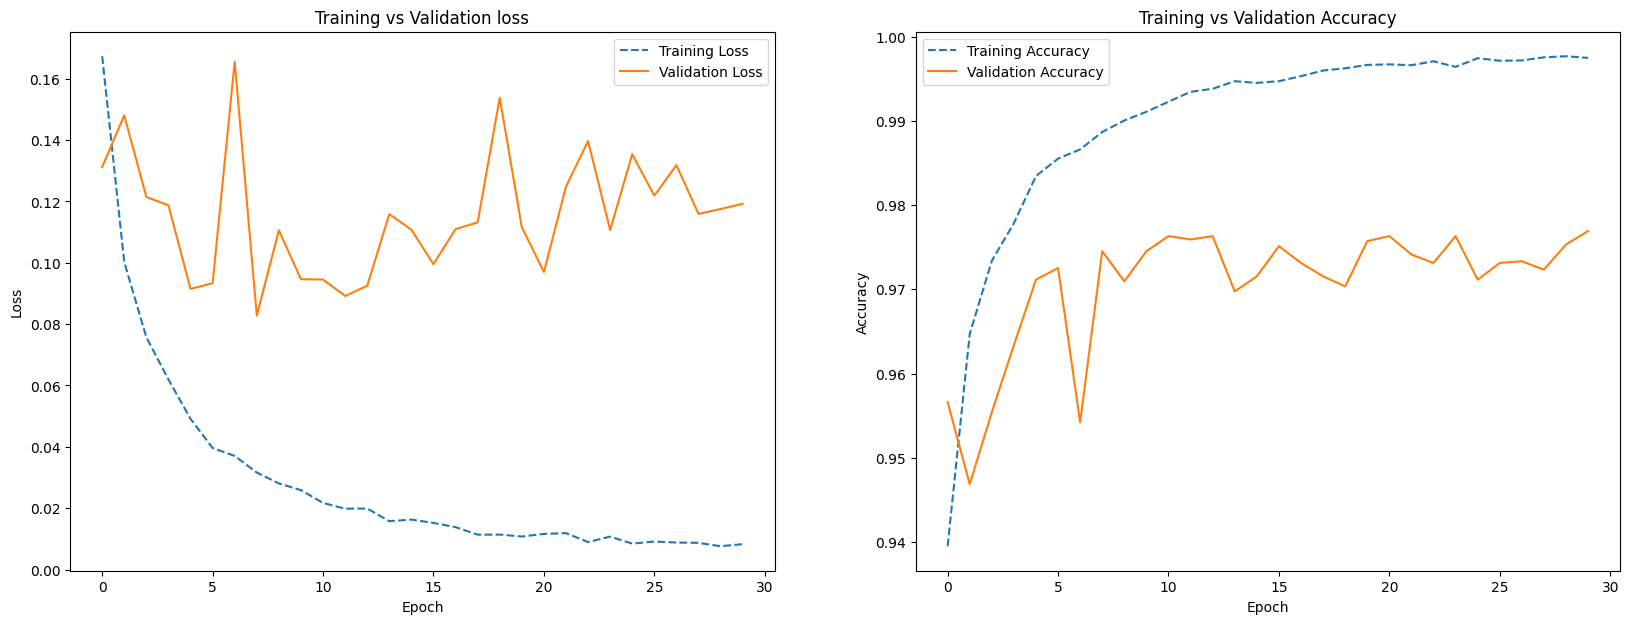

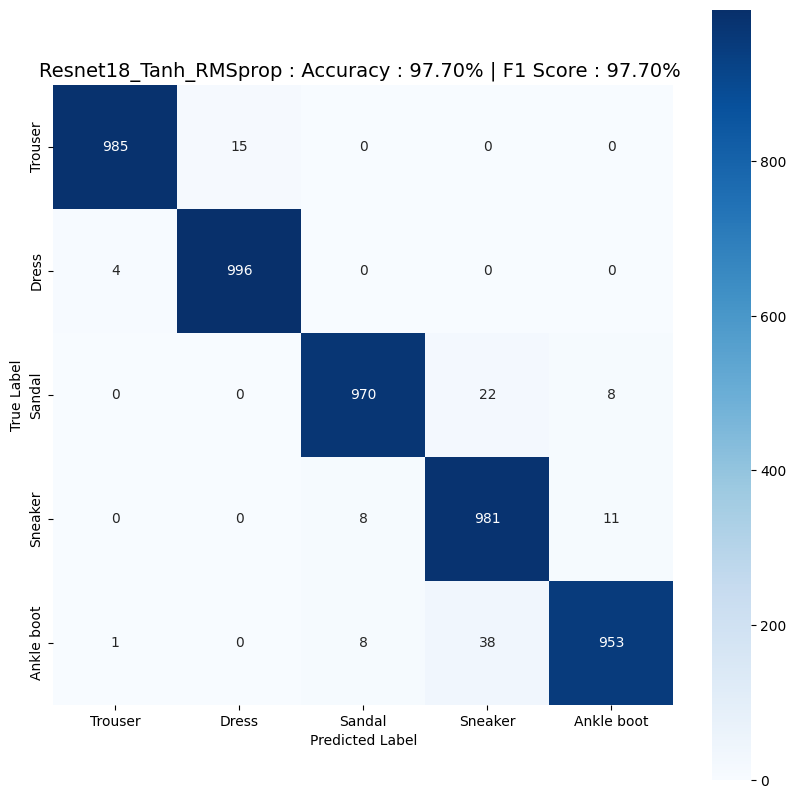

Accuracy: 97.700%
F1 Score: 97.703%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.985 |   0.996 |     0.97 |     0.981 |        0.953 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       985 |      15 |        0 |         0 |            0 |
| Dress        |         4 |     996 |        0 |         0 |            0 |
| Sandal       |         0 |       0 |      970 |        22 |            8 |
| Sneaker      |         0 |       0 |        8 |       981 |           11 |
| Ankle boot   |         1 |       0 |        8 |        38 |          953 |
Epoch: 1 (0m 19s) 	Training Loss: 0.780, 	Test Loss: 0.479,  	Training acc: 0.78, 	Test acc: 0.87, 
Epoch: 2 (0m 38s) 	Training Loss: 0.398, 	Test Loss: 0.339,  	Training acc: 0.89, 	Test acc:

<Figure size 640x480 with 0 Axes>

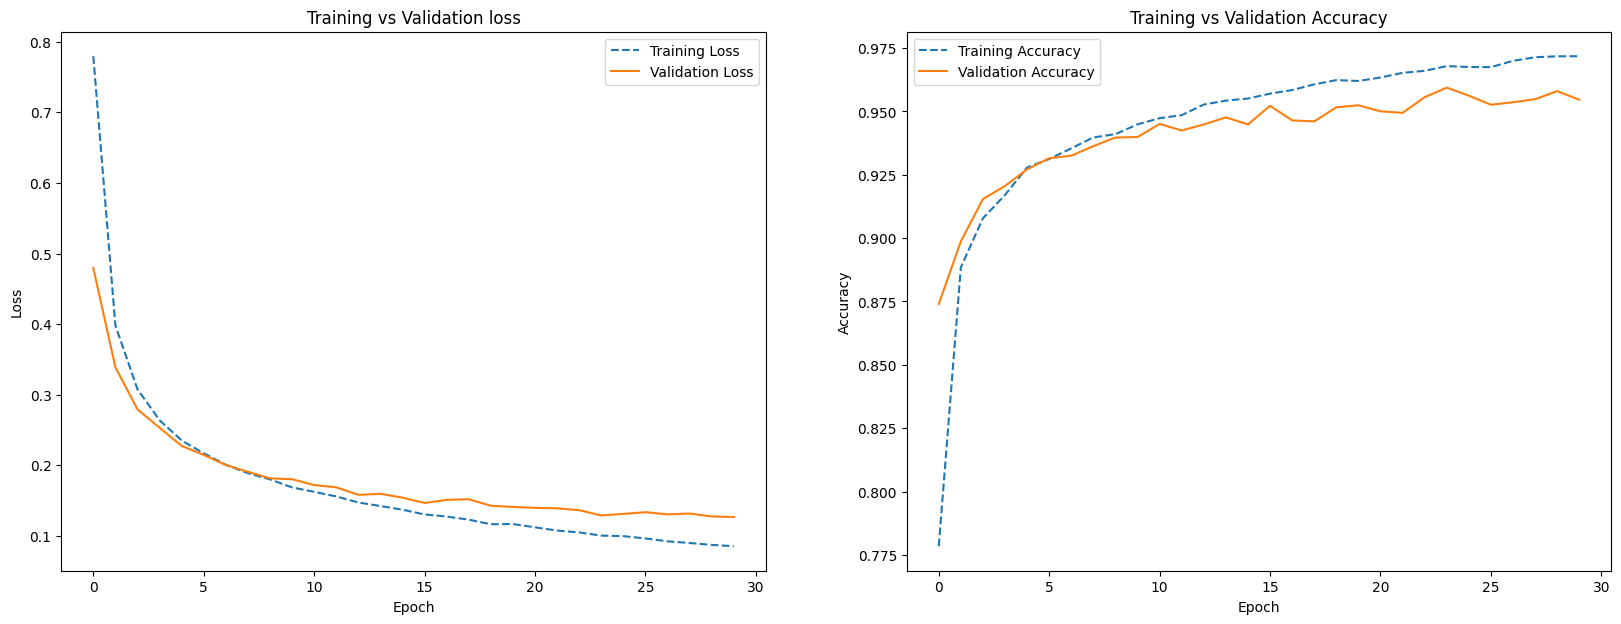

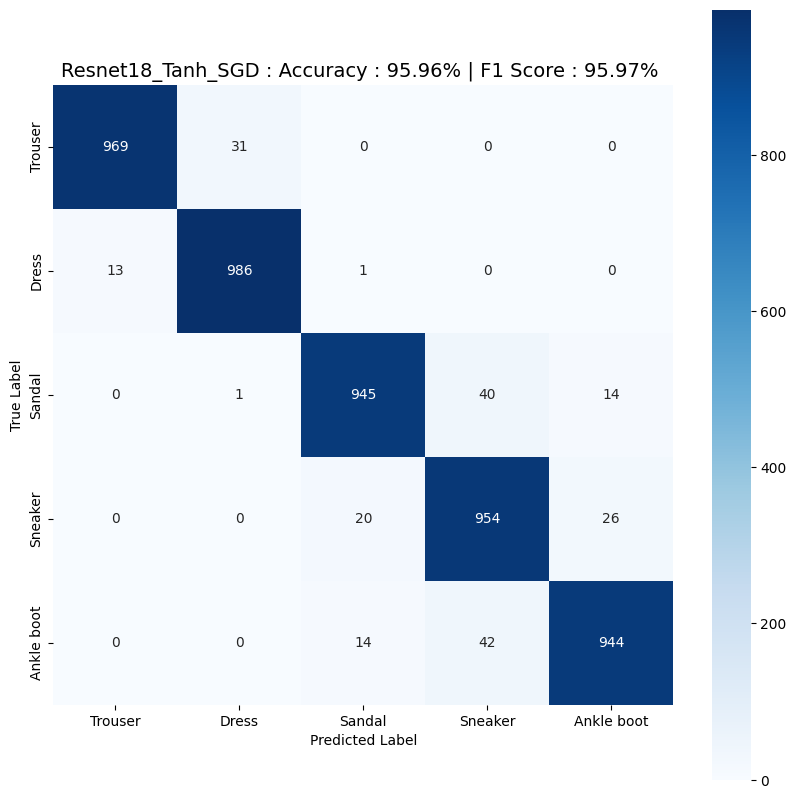

Accuracy: 95.960%
F1 Score: 95.966%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.969 |   0.986 |    0.945 |     0.954 |        0.944 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       969 |      31 |        0 |         0 |            0 |
| Dress        |        13 |     986 |        1 |         0 |            0 |
| Sandal       |         0 |       1 |      945 |        40 |           14 |
| Sneaker      |         0 |       0 |       20 |       954 |           26 |
| Ankle boot   |         0 |       0 |       14 |        42 |          944 |
Epoch: 1 (0m 23s) 	Training Loss: 0.166, 	Test Loss: 0.099,  	Training acc: 0.94, 	Test acc: 0.96, 
Epoch: 2 (0m 45s) 	Training Loss: 0.076, 	Test Loss: 0.101,  	Training acc: 0.97, 	Test acc:

<Figure size 640x480 with 0 Axes>

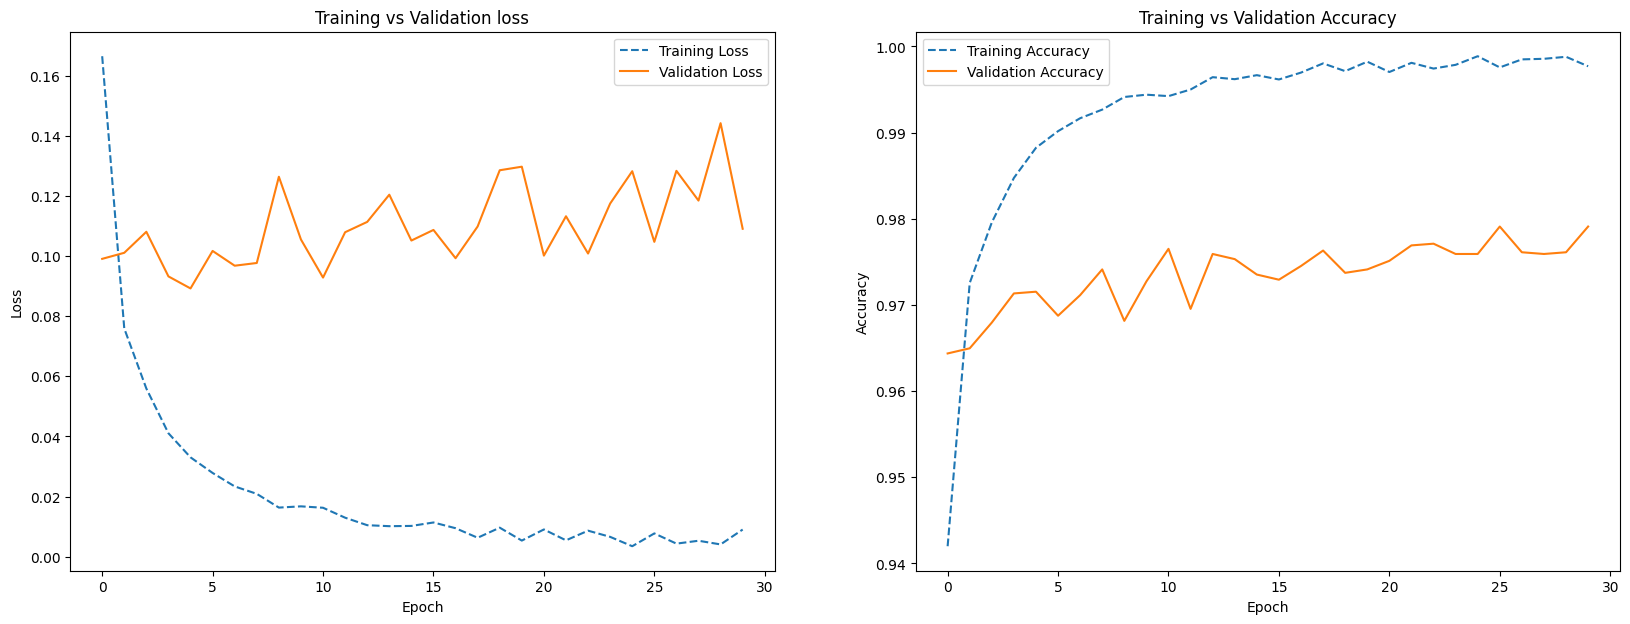

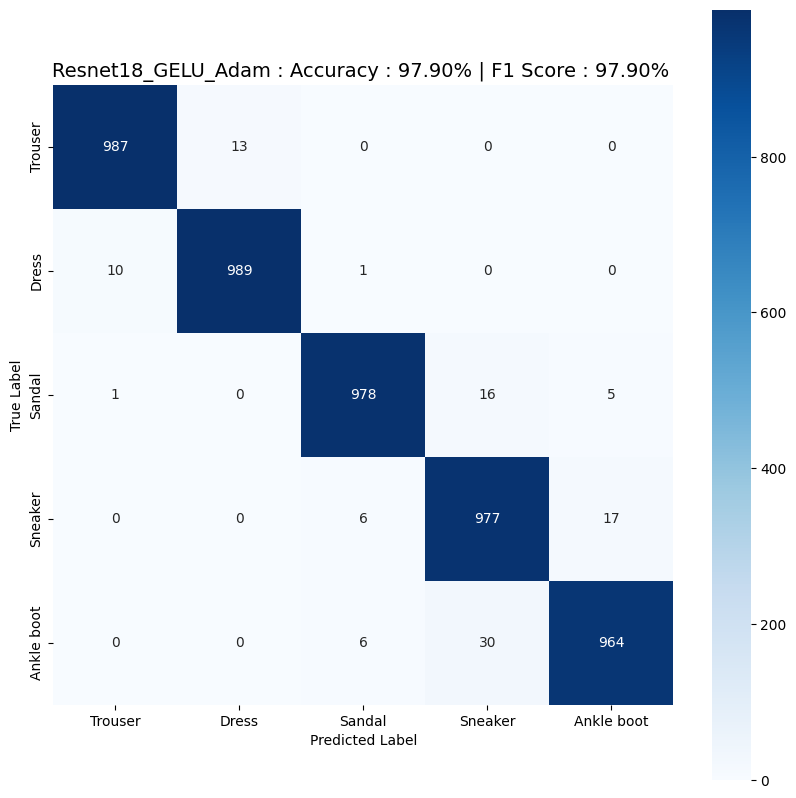

Accuracy: 97.900%
F1 Score: 97.902%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.987 |   0.989 |    0.978 |     0.977 |        0.964 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       987 |      13 |        0 |         0 |            0 |
| Dress        |        10 |     989 |        1 |         0 |            0 |
| Sandal       |         1 |       0 |      978 |        16 |            5 |
| Sneaker      |         0 |       0 |        6 |       977 |           17 |
| Ankle boot   |         0 |       0 |        6 |        30 |          964 |
Epoch: 1 (0m 20s) 	Training Loss: 0.272, 	Test Loss: 0.197,  	Training acc: 0.91, 	Test acc: 0.94, 
Epoch: 2 (0m 42s) 	Training Loss: 0.167, 	Test Loss: 0.173,  	Training acc: 0.94, 	Test acc:

<Figure size 640x480 with 0 Axes>

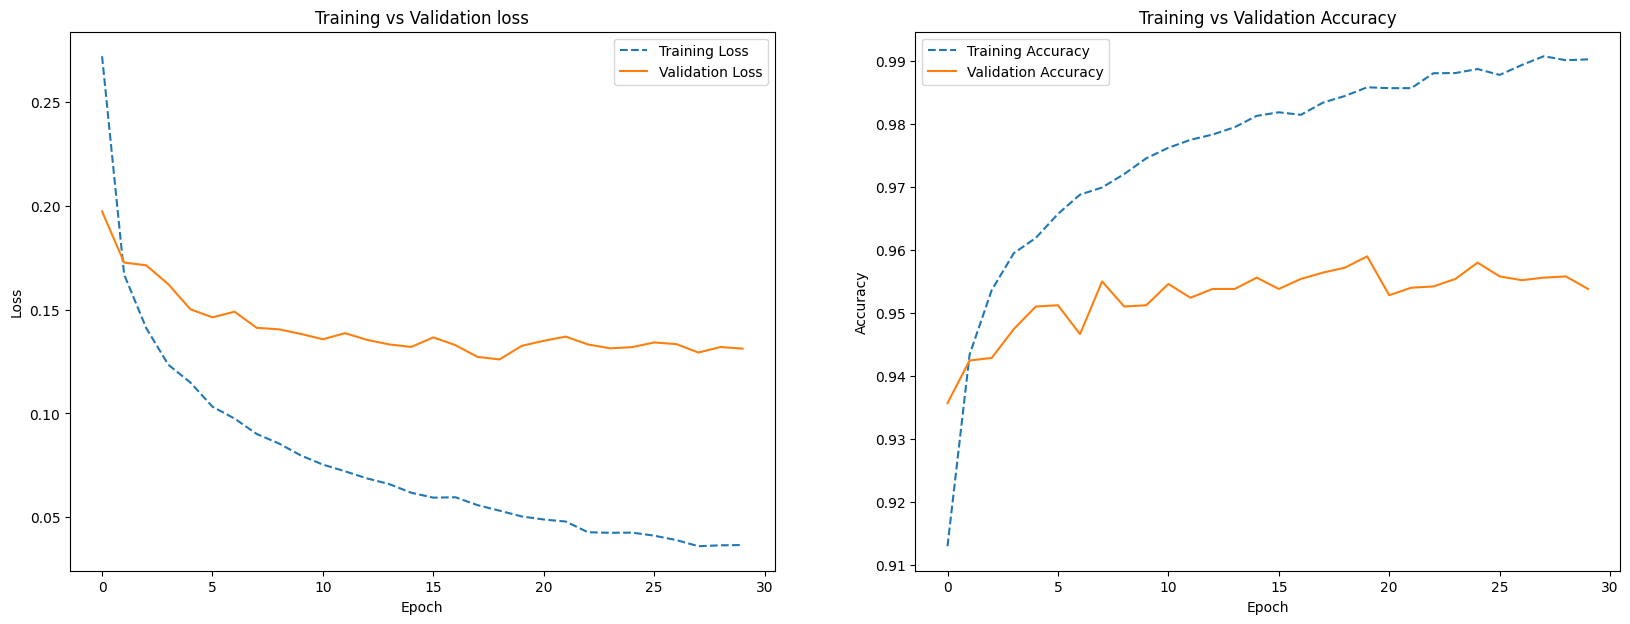

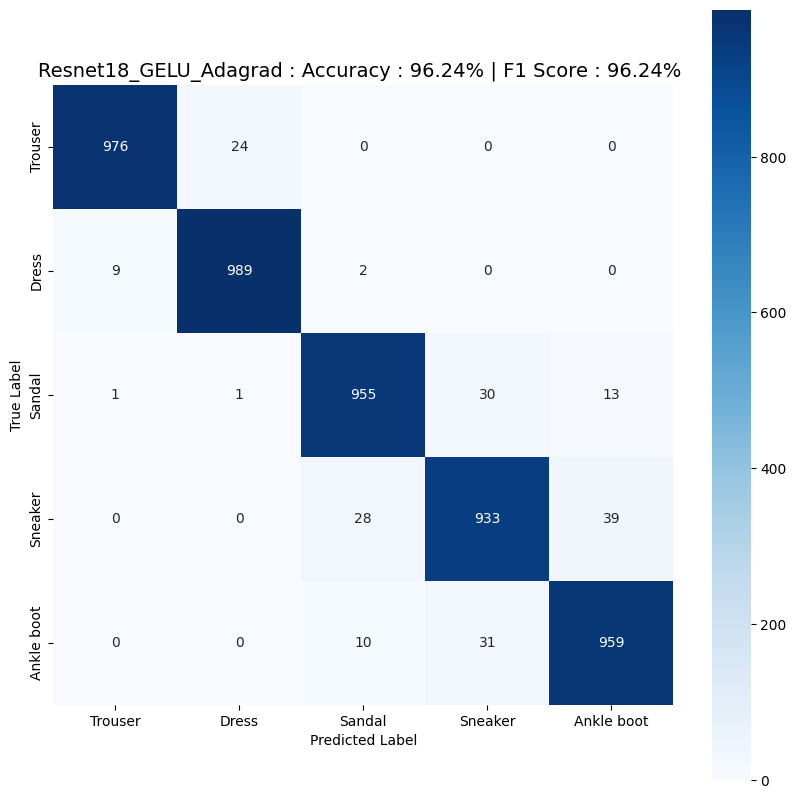

Accuracy: 96.240%
F1 Score: 96.239%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.976 |   0.989 |    0.955 |     0.933 |        0.959 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       976 |      24 |        0 |         0 |            0 |
| Dress        |         9 |     989 |        2 |         0 |            0 |
| Sandal       |         1 |       1 |      955 |        30 |           13 |
| Sneaker      |         0 |       0 |       28 |       933 |           39 |
| Ankle boot   |         0 |       0 |       10 |        31 |          959 |
Epoch: 1 (0m 20s) 	Training Loss: 0.155, 	Test Loss: 0.173,  	Training acc: 0.95, 	Test acc: 0.94, 
Epoch: 2 (0m 40s) 	Training Loss: 0.080, 	Test Loss: 0.093,  	Training acc: 0.97, 	Test acc:

<Figure size 640x480 with 0 Axes>

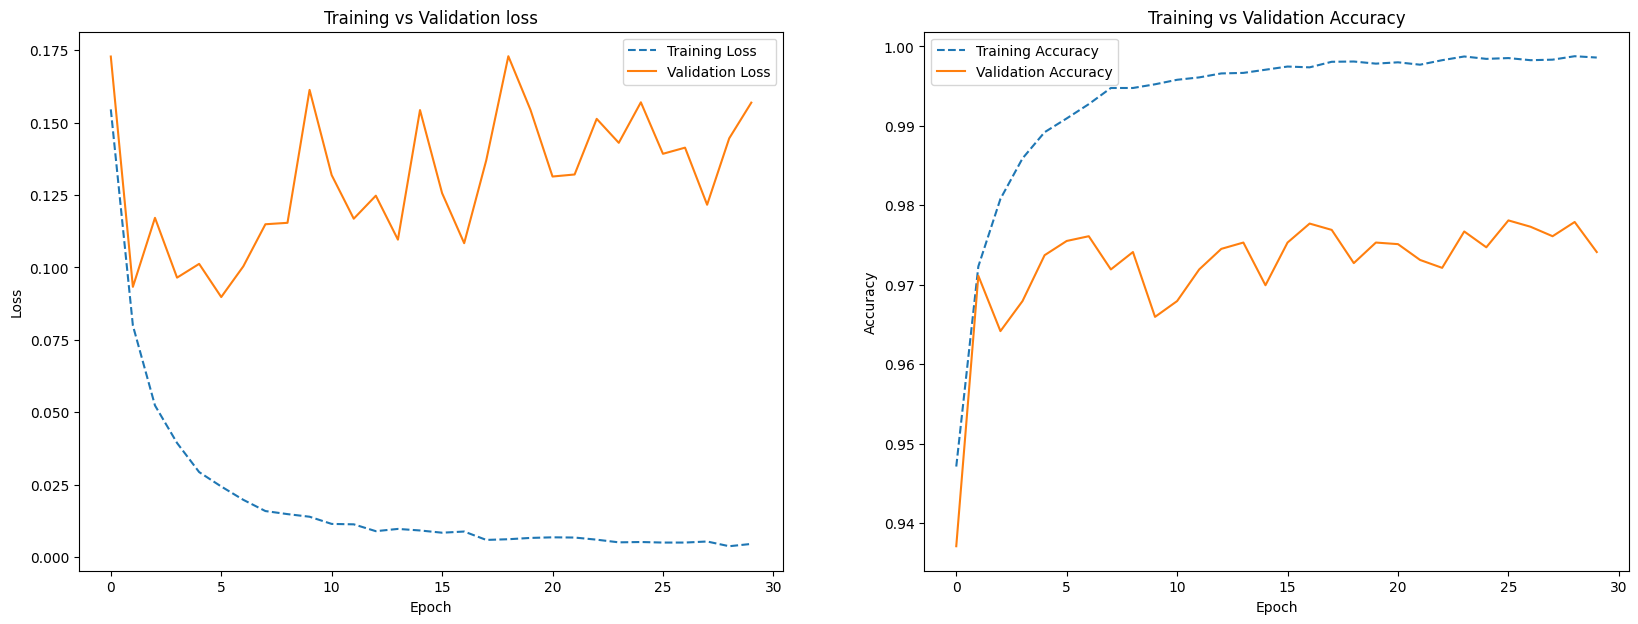

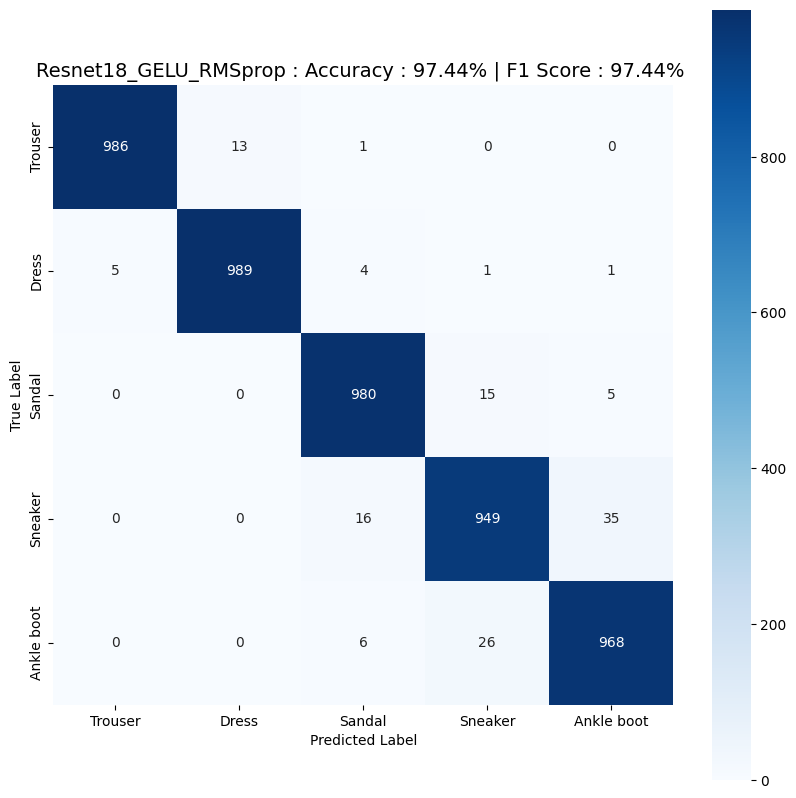

Accuracy: 97.440%
F1 Score: 97.440%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.986 |   0.989 |     0.98 |     0.949 |        0.968 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       986 |      13 |        1 |         0 |            0 |
| Dress        |         5 |     989 |        4 |         1 |            1 |
| Sandal       |         0 |       0 |      980 |        15 |            5 |
| Sneaker      |         0 |       0 |       16 |       949 |           35 |
| Ankle boot   |         0 |       0 |        6 |        26 |          968 |
Epoch: 1 (0m 19s) 	Training Loss: 0.923, 	Test Loss: 0.546,  	Training acc: 0.69, 	Test acc: 0.85, 
Epoch: 2 (0m 37s) 	Training Loss: 0.443, 	Test Loss: 0.380,  	Training acc: 0.87, 	Test acc:

<Figure size 640x480 with 0 Axes>

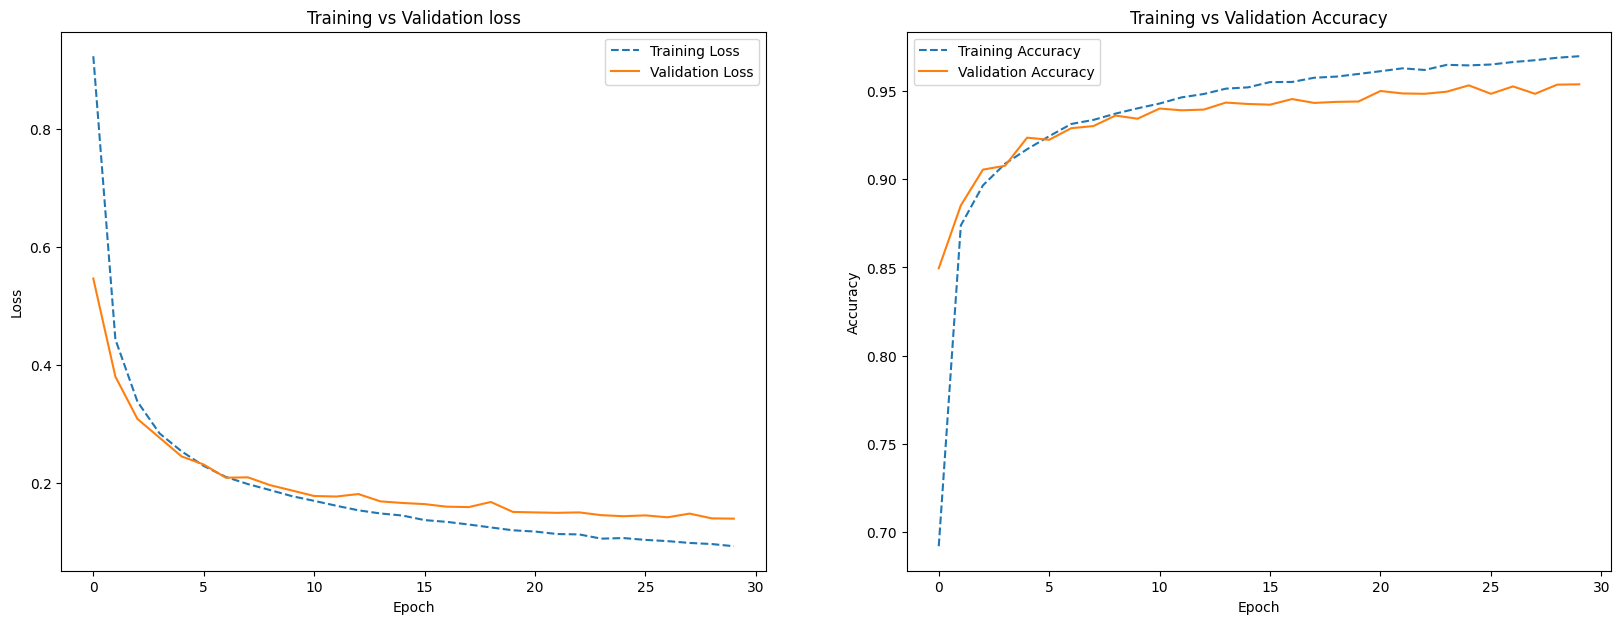

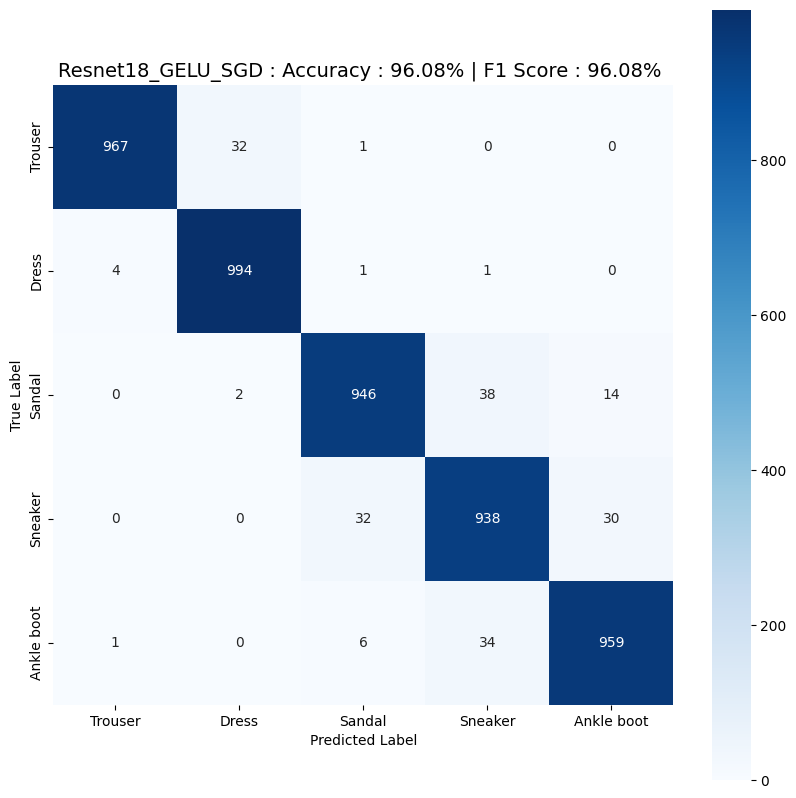

Accuracy: 96.080%
F1 Score: 96.082%

Classwise Accuracy Score: 
|   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|----------:|--------:|---------:|----------:|-------------:|
|     0.967 |   0.994 |    0.946 |     0.938 |        0.959 |

Confusion Matrix:
| True Label   |   Trouser |   Dress |   Sandal |   Sneaker |   Ankle boot |
|:-------------|----------:|--------:|---------:|----------:|-------------:|
| Trouser      |       967 |      32 |        1 |         0 |            0 |
| Dress        |         4 |     994 |        1 |         1 |            0 |
| Sandal       |         0 |       2 |      946 |        38 |           14 |
| Sneaker      |         0 |       0 |       32 |       938 |           30 |
| Ankle boot   |         1 |       0 |        6 |        34 |          959 |


Epoch,▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,▇▂▇▁▇▃█▃█▃▇▃
Training Accuracy,█▆█▂▇▇█▁█▆█▁
Training Time,█▇▆▂██▆▂▇▆▄▁
accuracy_score,▆▂▆▁▇▂▇▂█▃▇▃
epoch,▁▃▅▇▃▅▇▁▅▇▁▄▆█▃▅▇▂▅▇▁▃▇▁▃▆█▃▅▇▂▄▇▁▃▅▁▃▅█
epoch_time,▆█▇▆▆▆▆▅▅▅▃▂▃▃▆▅█▇▆▇▅▅▅▂▂▃▃▆▆▆▅▅▅▄▄▄▂▁▁▁
f1_score,▆▂▆▁▇▂▇▂█▃▇▃
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
train/train_accuracy,▇███▆▇▇▇██▁▅▆▇▇██▇▇█▇██▂▅▆▆███▆▇▇▇██▁▅▆▆
train/train_loss,▁▁▁▁▁▁▁▁▁█▂▁▁▅▁▁▁▂▄▃▁▁▁▄▂▂▁▃▁▁▁▂▁▁▁▁▃▁▁▁


<Figure size 640x480 with 0 Axes>

In [205]:
activation_fns = ['ReLU','Tanh','GELU']
optimisers = ['Adam','Adagrad','RMSprop','SGD']
lr = 1e-4
epoch = 30

for act_fn in activation_fns:
    for optimizer_name in optimisers:
        model = get_model(act_fn)
        optimizer =getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        loss_list, t, train_a, test_a = model_training(
            model, criterion, optimizer, trainloader, testloader, num_epochs=epoch)
        wandb.log({
            "Activation": act_fn,
            "Optimisers": optimizer_name,
            "learning_rate": lr,
            "Epoch": epoch,
            "Training Time": t,
            "Training Accuracy": train_a,
            "Test Accuracy": test_a,
        })
        plot_training_graphs(loss_list)
        model.eval()
        with torch.no_grad():
            test_labels = []
            test_output = []
            for batch_idx,batch in enumerate(testloader):
                x, y = batch
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                test_labels += y.cpu()
                test_output += torch.argmax(y_hat, dim=1).cpu()
                # Log one batch of images to the dashboard, always same batch_idx.
                if batch_idx%100==0 :
                    log_image_table(x, y_hat.argmax(axis=1), y, y_hat.softmax(dim=1))
            
            test_labels = np.array(test_labels)
            test_output = np.array(test_output)
            metric = confusionMatrixAndAccuracyReport(test_labels, test_output, test_set.classes,title=f'Resnet18_{act_fn}_{optimizer_name}')


# If you had a test set, this is how you could log it as a Summary metric
#wandb.summary['test_accuracy'] = 0.8

# 🐝 Close your wandb run
wandb.finish()
